In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
import os, sys, pickle
# from tqdm import tqdm

root_dir = os.path.dirname( os.path.abspath('') )
if not root_dir in sys.path: sys.path.append(root_dir)

from pathlib import Path
import time
from inference.BayesModel import *
from empirical.readData import *
from inference.utils.utils import adaptive_integration, p_nu, f

from DM_theory.functions import get_nu_bar, get_q

from ipywidgets import interact

%matplotlib widget

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [16]:
mP = ModelParams(
    mode="artificial",
    parameter={
        "distr": [{"gamma": 1.7, "delta": 4.5, "nu_max": 25.0}],
        "T": 100,
        "N": 1000,
    },
)
BM = BayesModel(mP)
BM.prepare_data(mP, mode="rates")
BM.set_priors(two_pop=False)
# BM.priors
my_logl = BM.set_logl(bias_to_mean=0, bias_to_expected_max=0)  # withZeros=True)
my_logl(np.array([1.7, 4.5, 25.0]))

{'distr': [{'gamma': 1.7, 'delta': 4.5, 'nu_max': 25.0}], 'T': 100, 'N': 1000}
input parameters: gamma=1.7, delta=4.5, nu_max=25.0, 
inferred parameters: rateWnt=[1.5959540910682242], tau_I=[0.004052847345693511], alpha_0=[array([[0.0346501]])], 


-992.0061705348456

In [3]:
# steps = 201
# gamma_arr = np.linspace(1.,2.5,steps)
# delta_arr = np.linspace(1.,10.,steps)
# nu_max = 25.
# gamma_mesh,delta_mesh = np.meshgrid(gamma_arr,delta_arr)

# logl_mesh = np.zeros((steps,steps))
# for j in range(steps):
#     logl_mesh[:,j] = my_logl(np.vstack([gamma_mesh[:,j],delta_mesh[:,j],np.full(steps,nu_max)]).T)
# logl_mesh

In [5]:
ref_values = {
    "distr": [{"gamma": 1.7, "delta": 4.5, "nu_max": 25.0}],
    "T": 1200,
    "N": 1000,
}
results = []
# for g,gamma in enumerate([1.7,2.1]):
for g, gamma in enumerate([1.7]):
    ref_values["distr"][0]["gamma"] = gamma
    mP = ModelParams(mode="artificial", parameter=ref_values)
    BM, res, sampler = run_sampling(mP, mode="dynesty", nP=8)
    results.append(res)

{'distr': [{'gamma': 1.7, 'delta': 4.5, 'nu_max': 25.0}], 'T': 1200, 'N': 1000}
input parameters: gamma=1.7, delta=4.5, nu_max=25.0, 
inferred parameters: rateWnt=[1.5959540910682242], tau_I=[0.004052847345693511], alpha_0=[array([[0.0346501]])], 
running nested sampling


822it [00:28, 28.94it/s, +100 | bound: 13 | nc: 1 | ncall: 19210 | eff(%):  4.825 | loglstar:   -inf < -2705.746 <    inf | logz: -2713.825 +/-  0.279 | dlogz:  0.009 >  1.000]


In [6]:
results[0]["posterior"]["mean"]

KeyError: 'posterior'

{'distr': [{'gamma': 1.7, 'delta': 4.5, 'nu_max': 25.0}], 'T': 10, 'N': 50}
{'distr': [{'gamma': 2.1, 'delta': 4.5, 'nu_max': 25.0}], 'T': 10, 'N': 50}


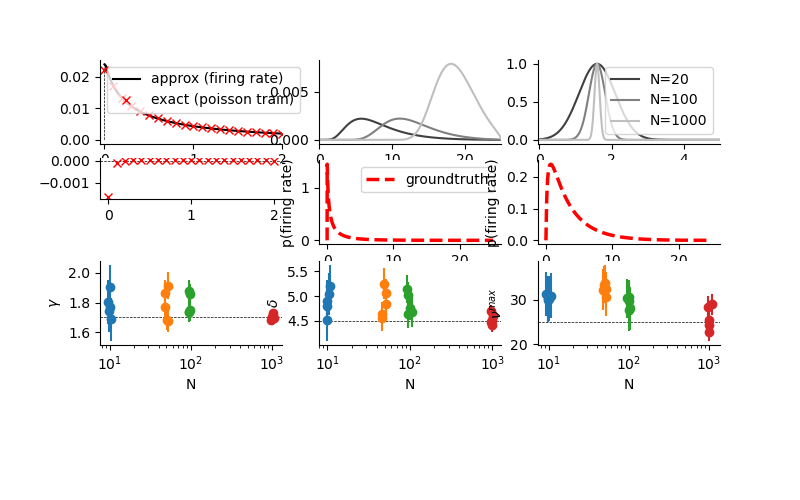

In [7]:
"""
define the figure as should be plotted for the paper
"""

steps = 20
params = {
    "distr": [{"gamma": 1.7, "delta": 4.5, "nu_max": 25.0}],
    "T": 60.0,
    "N": 100,
    "nAnimals": 5,
}

# params["p"] = 0.5
# params["gamma"] = params["gamma_2"]
# params["delta"] = 6.5

offset = 0.5 / params["T"]
two_pop = False

fig = plt.figure(figsize=(8, 5))  # , dpi=120)

ax_logp_points = fig.add_subplot(431)
ax_logp_points_error = fig.add_subplot(837)
ax_logp_max = fig.add_subplot(432)
ax_logp_mean = fig.add_subplot(433)


N_max = int(100 * params["T"])
nu_array = np.linspace(0, N_max / params["T"], N_max + 1)

nu_full = np.linspace(0, params["distr"][0]["nu_max"], 10001)
p_full = p_nu(nu_full, params) / params["T"]


## count based
N_max_steps = np.ceil(2 * params["T"] / steps) * steps
rateWnt_array = np.linspace(0, N_max_steps / params["T"], steps + 1)
p_N_AP = np.zeros(steps + 1)
for r, rateWnt in enumerate(rateWnt_array):
    p_N_AP[r] = adaptive_integration(
        f,
        0,
        params["distr"][0]["nu_max"],
        args=(params, np.array([rateWnt * params["T"]]), params["T"], two_pop),
    )

# p_N_AP_cont = (p_nu(nu_array[:-1],params,two_pop=two_pop) + p_nu(nu_array[1:],params,two_pop=two_pop)) / (2*params['T'])
p_N_AP_cont = p_nu(nu_array + offset, params) / params["T"]
p_N_AP_cont_points = p_nu(rateWnt_array + offset, params) / params["T"]

ax_logp_points.plot(nu_full, p_full, "k--", linewidth=0.5)
ax_logp_points.plot(nu_array, p_N_AP_cont, "k", label="approx (firing rate)")
# ax_logp_points.plot(rateWnt_array,p_N_AP_cont_points,'rx')
ax_logp_points.plot(rateWnt_array, p_N_AP, "rx", label="exact (poisson train)")

p_N_AP_error = p_N_AP - p_N_AP_cont_points
ax_logp_points_error.axhline(0, color="k", linestyle="--", linewidth=0.5)
ax_logp_points_error.plot(rateWnt_array, p_N_AP_error, "rx")

plt.setp(ax_logp_points, xlim=[-0.05, 2])


### plotting extreme value distribution
### and mean
for n, nNeurons in enumerate([20, 100, 1000]):
    ## ... extreme value distribution
    p_N_AP_cum = np.pad(
        np.cumsum(p_N_AP_cont) ** nNeurons, (1, 0), mode="constant", constant_values=0
    )
    # print(p_N_AP_cum, p_N_AP_cum.shape)
    p_extreme = np.diff(p_N_AP_cum)
    p_extreme *= 1 - 1.0 / (params["distr"][0]["nu_max"] - nu_array + 1) ** 2
    ax_logp_max.plot(nu_array, p_extreme, color=[(n + 1) / 4] * 3)

    ## ... and mean
    nu_mean = get_nu_bar(
        params["distr"][0]["gamma"],
        params["distr"][0]["delta"],
        params["distr"][0]["nu_max"],
    )
    nu_SD = get_q(
        params["distr"][0]["gamma"],
        params["distr"][0]["delta"],
        params["distr"][0]["nu_max"],
    )

    nu_sigma = np.sqrt(nu_SD - nu_mean**2) / np.sqrt(nNeurons)
    # print(f'{nu_mean=}, {nu_SD=}, {nu_sigma=}')

    mean_distribution = np.exp(
        -((nu_array - nu_mean) ** 2) / (2 * nu_sigma**2)
    )  # 1/np.sqrt(2*np.pi*nu_sigma**2)
    ax_logp_mean.plot(
        nu_array, mean_distribution, color=[(n + 1) / 4] * 3, label=f"N={nNeurons}"
    )

plt.setp(ax_logp_mean, xlim=[-0.05, 5], xlabel="$\\bar{\\nu}$")
plt.setp(ax_logp_max, xlim=[-0.05, params["distr"][0]["nu_max"]], xlabel="$\\nu$")
ax_logp_mean.legend()
ax_logp_points.legend()

for axx in [ax_logp_points, ax_logp_points_error, ax_logp_max, ax_logp_mean]:
    axx.spines[["top", "right"]].set_visible(False)


ref_values = {"distr": [{"gamma": 1.5, "delta": 4.5, "nu_max": 25.0}], "T": 10, "N": 50}

nu_array = np.linspace(0, 50, 10001)

for g, gamma in enumerate([1.7, 2.1]):
    ax_compare = fig.add_subplot(4, 3, 5 + g)
    ref_values["distr"][0]["gamma"] = gamma
    # mP = ModelParams(mode='artificial',**ref_values)
    # BM, results, sampler = run_sampling(mP)
    print(ref_values)
    ax_compare.plot(
        nu_array,
        p_nu_single(
            nu_array,
            ref_values["distr"][0]["gamma"],
            ref_values["distr"][0]["delta"],
            ref_values["distr"][0]["nu_max"],
        ),
        "r--",
        linewidth=2.5,
        label="groundtruth" if g == 0 else None,
    )
    # ax_compare.plot(
    #     nu_array,
    #     p_nu_single(nu_array, *results[g]["posterior"]["mean"]),
    #     "k-",
    #     label="inferred" if g == 0 else None,
    # )
    plt.setp(ax_compare, xlabel="firing rate", ylabel="p(firing rate)")
    ax_compare.spines[["top", "right"]].set_visible(False)
    if g == 0:
        ax_compare.legend()

res = pickle.load(open("../test_inference_results_N.pkl", "rb"))

ax_N_gamma = fig.add_subplot(4, 3, 7)
ax_N_delta = fig.add_subplot(4, 3, 8)
ax_N_nu_max = fig.add_subplot(4, 3, 9)

ax_inf = [ax_N_gamma, ax_N_delta, ax_N_nu_max]

ref_values = {"distr": [{"gamma": 1.7, "delta": 4.5, "nu_max": 25.0}], "T": 10, "N": 50}

title_values = {"gamma": "$\gamma$", "delta": "$\delta$", "nu_max": "$\\nu^{max}$"}


for j, var in enumerate(["gamma", "delta", "nu_max"]):
    ax_inf[j].axhline(
        ref_values["distr"][0][var],
        color="k",
        linestyle="--",
        linewidth=0.5,
        label="groundtruth",
    )
    for i, val in enumerate(res.keys()):
        n_repeat = res[val]["mean"].shape[0]
        ax_inf[j].errorbar(
            val * (1 + np.random.randn(n_repeat) / 20.0),
            res[val]["mean"][:, j],
            yerr=res[val]["stdev"][:, j],
            fmt="o",
        )

    ax_inf[j].set_xscale("log")
    ax_inf[j].spines[["top", "right"]].set_visible(False)
    plt.setp(ax_inf[j], xlabel="N", ylabel=title_values[var])


# ax = fig.add_subplot(435,projection='3d')

# ax.plot_surface(gamma_mesh,delta_mesh,logl_mesh,alpha=0.6,antialiased=False)
# plt.setp(ax,zlim=[-4000,-3000],xlabel='$\gamma$',ylabel='$\\delta$',zlabel='logL')
# ax.view_init(20, -15)


# plt.tight_layout()

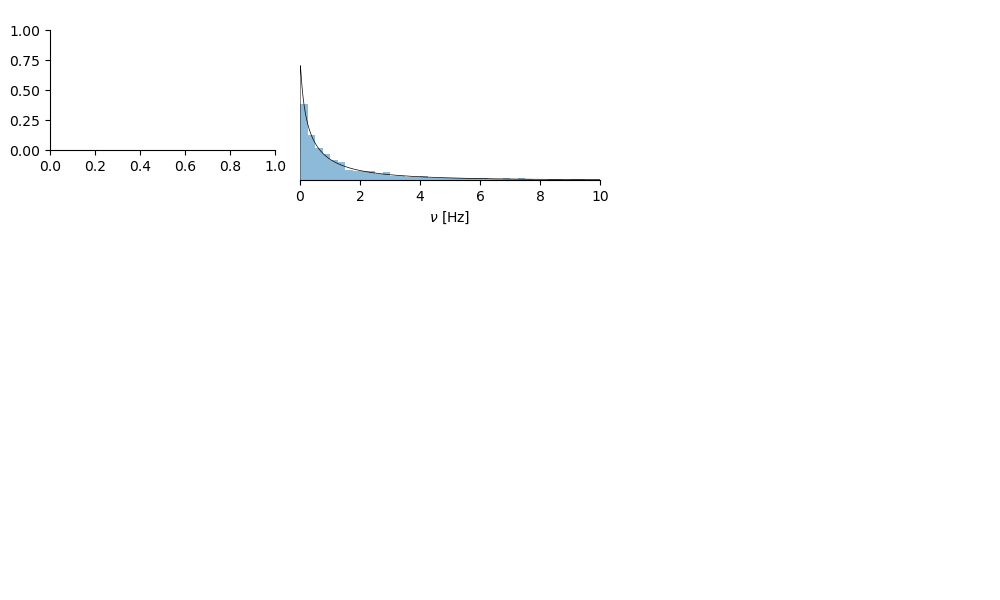

In [8]:
nu_full = np.linspace(0, params["distr"][0]["nu_max"], 10001)
p_full = p_nu(nu_full, params)  # / params["T"]

dnu = params["distr"][0]["nu_max"] / (51 - 1)
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 1)
ax_p_nu = fig.add_subplot([0.3, 0.7, 0.3, 0.2])
ax_p_nu.plot(nu_full, p_full * 2 * dnu, "k-", linewidth=0.5)

ax_p_nu.hist(
    mP.rates[:, 0],
    bins=np.linspace(0, params["distr"][0]["nu_max"], 101),
    density=True,
    alpha=0.5,
)
# ax_logp_points.plot(nu_array, p_N_AP_cont, "k", label="approx (firing rate)")
# ax_logp_points.plot(rateWnt_array,p_N_AP_cont_points,'rx')
# ax_logp_points.plot(rateWnt_array, p_N_AP, "rx", label="exact (poisson train)")

plt.setp(ax_p_nu, xlim=[0, 10], yticks=[], xlabel="$\\nu$ [Hz]")
ax_p_nu.spines[["top", "right", "left"]].set_visible(False)

ax_p_low = fig.add_subplot([0.05, 0.75, 0.225, 0.2])
y_vals = f(nu_array, p=params, N_AP=np.array([rateWnt * params["T"]]), T=params["T"])
yy = y_vals[np.isfinite(y_vals)]

# h_ax_single.set_data(nu_array, y_vals)
# plt.setp(ax_single, xlim=[0, 2], ylim=[0, 1.25 * np.nanmax(yy)])

ax_p_low.spines[["top", "right"]].set_visible(False)

In [9]:
# from scipy.special import factorial as sp_factorial
# from scipy.special import binom as sp_binom

# def rho_nu(nu,gamma,delta,nu_max):
#     return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
#         np.exp( - delta**2/2.) * ( nu / nu_max )**(gamma**2 - 1) * \
#         np.cosh( gamma * delta * np.sqrt( -2 * np.log( nu / nu_max) ) )

# def poisson_spikes(nu,N,T):
#     ## use log to avoid overflow
#     return np.exp(N*np.log(nu*T) - np.log(sp_factorial(N)) - nu*T)

# def f(nu,gamma,delta,nu_max,N_AP,T):
#     print(gamma,delta,nu_max)
#     return rho_nu(nu,gamma,delta,nu_max) * poisson_spikes(nu,N_AP[:,np.newaxis],T)

In [10]:
import copy


def load_results(base_path, parameters, n_repeat):
    # print(base_path,parameters,n_repeat)
    fileName = base_path
    for key, val in parameters.items():
        # print(key,val)
        fileName += f"_{key}={val:d}" if isinstance(val, int) else f"_{key}={val:g}"
    fileName = Path(f"{fileName}_{n_repeat}.pkl")
    # print(fileName)
    if Path(fileName).is_file():
        try:
            with open(fileName, "rb") as f_open:
                return pickle.load(f_open)
        except:
            pass


def custom_violin(
    ax,
    data,
    pos,
    fc="b",
    ec="k",
    alpha=0.7,
    percentiles=[25, 50, 75],
    side="both",
    scatter_kwargs={},
    violin_kwargs={},
):
    """Customized violin plot.
    ax: axes.Axes, The axes to plot to
    data: 1D array like, The data to plot
    pos: float, The position on the x-axis where the violin should be plotted
    fc: color, The facecolor of the violin
    ec: color, The edgecolor of the violin
    alpha: float, The transparancy of the violin
    percentiles: array like, The percentiles to be marked on the violin
    side: string, Which side(s) of the violin should be cut off. Options: 'left', 'right', 'both'
    scatter_kwargs: dict, Keyword arguments for the scatterplot
    violin_kwargs: dict, Keyword arguments for the violinplot"""

    parts = ax.violinplot(data, positions=[pos], **violin_kwargs)
    for pc in parts["bodies"]:
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        if side == "left":
            points_x = pos - 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(
                pc.get_paths()[0].vertices[:, 0], -np.inf, m
            )
        elif side == "right":
            points_x = pos + 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(
                pc.get_paths()[0].vertices[:, 0], m, np.inf
            )
        else:
            points_x = pos
        pc.set_facecolor(fc)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)
        parts["cmeans"].set_color(fc)


def plot_results(
    ax,
    var,
    iter_key,
    iter_vals,
    n_repeat,
    # ref_values=None,
    correct_N=5,
    bias_to_expected_max=0,
    bias_to_mean=0,
    base_path="../results_inference/24_11_13/inference_test",
    save=False,
    log=False,
    **kwargs,
):

    mode_str = "_modes"
    if correct_N > 0:
        mode_str += f"_{correct_N=}"
    if bias_to_expected_max > 0:
        mode_str += f"_{bias_to_expected_max=}"
    if bias_to_mean > 0:
        mode_str += f"_{bias_to_mean=}"

    base_path += mode_str
    # print(base_path)
    # N_array = np.array(list(res.keys()))
    # if ref_values is None:
    ref_vals = {
        "gamma_1": 1.7,
        "delta_1": 4.5,
        "nu_max_1": 25.0,
        "T": 1200,
        "N": 1000,
    }
    # else:
    # 	ref_vals = copy.deepcopy(ref_values)

    for key in ref_vals.keys():
        if key in kwargs.keys():
            ref_vals[key] = kwargs[key]
    # print(ref_vals)

    # para_keys = []
    # for key in ref_vals.keys():
    #     if key!='N' and key!='T':
    #         para_keys.append(key)

    # title_vals = {
    #     'gamma_1': r'$\gamma$',
    #     'delta_1': r'$\delta$',
    #     'nu_max_1': r'$\nu_{\max}$',
    #     'gamma_2': r'$\gamma_2$',
    #     'delta_2': r'$\delta$_2',
    #     'nu_max_2': r'$\nu_{\max}$',
    #     'p': r'$p$',
    #     'T': 'T',
    #     'N': 'N',
    #     'nAnimals': '# animals'
    # }

    # # print(para_keys)
    # nParams = 4 if 'p' in para_keys else 3
    # fig, ax = plt.subplots(4+nParams,1,figsize=(5,12),sharex=True)
    # # print(nParams)
    # ax_param_idx = 2
    # ax_distr = ax[0]
    # ax_finished = ax[1]

    # ax_time = ax_finished.twinx()

    # ax_KL = ax[ax_param_idx+nParams]
    # ax_KS = ax[ax_param_idx+nParams+1]

    # colors = ['tab:blue']
    # if 'p' in para_keys:
    #     colors.append('tab:orange')

    x_range = iter_vals[-1] - iter_vals[0]
    if log:
        x_offset = lambda x, factor: np.exp(factor * np.log(x))
        xlims = [
            iter_vals[0] / x_offset(x_range, 0.1),
            iter_vals[-1] * x_offset(x_range, 0.05),
        ]
    else:
        x_offset = lambda x, factor: factor * x
        xlims = [
            iter_vals[0] - x_offset(x_range, 0.25),
            iter_vals[-1] + x_offset(x_range, 0.1),
        ]
    prior_baseline = iter_vals[0] - x_offset(x_range, 0.1)

    # # one_distr = not iter_key.startswith(('gamma','delta','nu_max'))
    # one_distr = False
    # multi_distr = iter_key.startswith(('gamma','delta','nu_max'))
    # if one_distr:

    #     nu_array = np.linspace(0,ref_vals['nu_max_1'],10001)
    #     rho = p_nu(nu_array,ref_vals)
    #     # if log:
    #         # rho = np.exp(rho)
    #     # ax_distr.plot(val - rho,nu_array,'k-',linewidth=0.5)
    #     ax_distr.fill_between(x=nu_array,y1=rho,y2=0,alpha=0.5,color='b')

    s_kwargs = {"s": 40, "marker": "_"}
    for i, val in enumerate(iter_vals):

        ref_vals[iter_key] = val

        if log:
            # val_offset =
            # val_pos = val * np.exp(0.005*np.log(x_range))
            val_width = val * x_offset(x_range, 0.01)
            val_scatter = val * np.exp(
                +np.random.randn(n_repeat) * 0.005 * np.log(x_range)
            )
        else:
            val_width = x_offset(x_range, 0.1)
            val_scatter = val + np.random.randn(n_repeat) * 0.01 * x_range

        v_kwargs = {
            "showextrema": False,
            "showmedians": False,
            "showmeans": True,
            "widths": val_width,
        }

        # ''' PLOT REFERENCE DISTRIBUTION'''
        # if (multi_distr or i==0):
        #     nu_array = np.linspace(0,ref_vals['nu_max_1'],10001)
        #     rho = p_nu(nu_array,ref_vals)*x_offset(x_range,0.1)
        #     if log:
        #         rho = np.exp(rho)
        #     # ax_distr.plot(val - rho,nu_array,'k-',linewidth=0.5)
        #     ax_distr.fill_betweenx(y=nu_array,x1=val+rho,x2=val,alpha=0.5,color='b')

        # for idx,c in enumerate(colors):
        # for j,var in enumerate([f'gamma_{idx+1}',f'delta_{idx+1}',f'nu_max_{idx+1}','p']):
        # for j,var in enumerate(para_keys):
        # label_str = 'truth' if i==0 and j==0 else None
        if var == iter_key:
            ax.plot(iter_vals, iter_vals, "k--", linewidth=0.5)  # ,label=label_str)
        else:
            ax.axhline(
                ref_vals[var], color="k", linestyle="--", linewidth=0.5
            )  # ,label=label_str)

        # result_blueprint = np.full(n_repeat,np.NaN)
        # result_CI_blueprint = np.full((n_repeat,2),np.NaN)
        results = {
            "mean": np.full(n_repeat, np.NaN),
            # 'stdev': {},
            "CI": np.full((n_repeat, 2), np.NaN),
            # 'KL': np.full(n_repeat,np.NaN),
            # 'KS': np.full(n_repeat,np.NaN),
            # 'time_taken': np.full(n_repeat,np.NaN)
        }
        # for key in para_keys:
        # 	results['mean'] = copy.deepcopy(result_blueprint)
        # 	# results['stdev'][key] = copy.deepcopy(result_blueprint)
        # 	results['CI'] = copy.deepcopy(result_CI_blueprint)

        # print(results['mean'].keys())
        for n in range(n_repeat):

            res = load_results(base_path, ref_vals, n)
            # print(base_path, res)
            if res:
                try:
                    # for i,key in enumerate(para_keys):

                    # if var.startswith('nu_max') and key[-1]!='1':#idx>0:
                    # 	continue
                    # print(res['posterior'][key]['mean'])
                    results["mean"][n] = res["posterior"][var]["mean"]
                    # results['stdev'][key][n] = res['posterior'][key]['CI']
                    results["CI"][n, :] = res["posterior"][var]["CI"][[1, -2]]
                except:
                    pass
                    # for key in para_keys:

                    #     results['mean'][key][n] = res['mean'][key]
                    #     results['stdev'][key][n] = res['stdev'][key]

                # results['KL'][n] = res['KL']
                # results['KS'][n] = res['KS']

                # results['time_taken'][n] = res['time_taken']

        # for idx,c in enumerate(colors):
        # 	for j,var in enumerate([f'gamma_{idx+1}',f'delta_{idx+1}',f'nu_max_{idx+1}']):

        if np.all(np.isnan(results["mean"])):
            continue

        # if var.startswith('nu_max') and var[-1]!='1':#idx>0:
        # 	continue

        ax.errorbar(
            val_scatter,
            results["mean"],
            yerr=np.abs(results["mean"][:, np.newaxis] - results["CI"]).T,
            fmt="o",
            markersize=0.3,
            linewidth=0.2,
            color="gray",
        )  # ,label='inference results' if (i==0 and j==0 and idx==0) else None)

        custom_violin(
            ax,
            results["mean"][np.isfinite(results["mean"])],
            val,
            "tab:blue",
            "tab:blue",
            0.6,
            side="right",
            scatter_kwargs=s_kwargs,
            violin_kwargs=v_kwargs,
        )

    if log:  # and not one_distr:
        ax.set_xscale("log")

        # if idx==0:
        # plt.setp(ax,ylabel=title_vals[var])

        # if 'p' in para_keys and not np.all(np.isnan(results['mean']['p'])):
        # 	var = 'p'
        # 	c = 'tab:blue'
        # 	# ax[ax_param_idx+3].errorbar(val_scatter,results['mean'][var],yerr=results['stdev'][var],fmt='o',markersize=0.3,linewidth=0.2,color='gray')
        # 	ax.errorbar(val_scatter,results['mean'][var],yerr=np.abs(results['mean'][var][:,np.newaxis]-results['CI'][var]).T,fmt='o',markersize=0.3,linewidth=0.2,color='gray')

        # 	custom_violin(ax[ax_param_idx+3], results['mean'][var][np.isfinite(results['mean'][var])], val, c, c, 0.6, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)

        # 	plt.setp(ax[ax_param_idx+3],ylabel=title_vals[var])

        # ''' PLOT TEST STATISTICS '''
        # ax_KL.scatter(val_scatter,results['KL'],color='k',s=2)
        # ax_KS.scatter(val_scatter,results['KS'],color='k',s=2)

        # n_finished = np.isfinite(results['mean']['gamma_1']).sum()
        # ax_finished.plot(val,n_finished,'ko')

        # ax_time.scatter(val_scatter,results['time_taken'],color='grey',s=0.5)

    # ax_finished.axhline(n_repeat,color='k',linestyle='--',linewidth=0.5)
    return

    # """ PLOT PRIOR DISTRIBUTIONS """
    # exponential_fun = lambda x, mu, sigma: np.exp(
    #     -((x - mu) ** 2) / (2 * sigma**2)
    # )  # /np.sqrt(2*np.pi*sigma**2)

    # nu_array = np.linspace(0, 100, 1001)
    # delta_array = np.linspace(0, 10, 1001)
    # gamma_array = np.linspace(0.5, 3, 1001)

    # gamma_prior = x_offset(x_range, 0.1) * exponential_fun(gamma_array, 2.0, 0.5)
    # delta_prior = x_offset(x_range, 0.1) * exponential_fun(delta_array, 6.0, 2.0)
    # nu_prior = x_offset(x_range, 0.1) * exponential_fun(nu_array, 0.0, 50.0)

    # ax[ax_param_idx + 0].fill_betweenx(
    #     y=gamma_array,
    #     x1=prior_baseline - gamma_prior,
    #     x2=prior_baseline,
    #     alpha=0.5,
    #     color="tab:green",
    #     label="prior",
    # )
    # ax[ax_param_idx + 1].fill_betweenx(
    #     y=delta_array,
    #     x1=prior_baseline - delta_prior,
    #     x2=prior_baseline,
    #     alpha=0.5,
    #     color="tab:green",
    # )
    # ax[ax_param_idx + 2].fill_betweenx(
    #     y=nu_array,
    #     x1=prior_baseline - nu_prior,
    #     x2=prior_baseline,
    #     alpha=0.5,
    #     color="tab:green",
    # )

    # """ ADJUST AXES PROPERTIES """
    # ax[ax_param_idx].legend(
    #     bbox_to_anchor=(0.05, 0.95), loc="upper left", borderaxespad=0.0
    # )

    # plt.setp(ax[ax_param_idx], ylim=[1.0, 3.5])
    # plt.setp(ax[ax_param_idx + 1], ylim=[2.5, 10])
    # plt.setp(ax[ax_param_idx + 2], ylim=[10, 60])
    # plt.setp(ax_finished, ylim=[0, n_repeat * 1.1], ylabel="finished runs")

    # plt.setp(ax_KL, ylabel="KL div.")
    # plt.setp(ax_KS, ylabel="KS stat.")

    # if one_distr:
    #     plt.setp(ax_distr, xlim=[0, 2], xlabel="rate [Hz]")
    # else:
    #     plt.setp(ax_distr, ylim=[0, 2], ylabel="rate [Hz]", xlim=xlims)

    # ax_time.set_yscale("log")
    # plt.setp(
    #     ax_time, ylim=[10**1, 10**5], ylabel="computation time [s]", xlim=xlims
    # )  # ,xticklabels=[])

    # for j, axx in enumerate(ax):
    #     axx.spines[["top", "right"]].set_visible(False)
    #     # plt.setp(axx,xlim=xlims)

    #     # if j<6:
    #     # plt.setp(axx,xticklabels=[])
    #     if j == (nParams + 4 - 1):
    #         plt.setp(axx, xlabel=title_vals[iter_key])

    # ax_time.spines[["top", "left"]].set_visible(False)

    # plt.tight_layout(h_pad=0.1)

    # if save:
    #     file_format = "png"
    #     sv_name = f"./figures/inference_tests_pop={'2' if 'p' in para_keys else '1'}_{iter_key}.{file_format}"
    #     plt.savefig(sv_name)
    #     print('Figure saved as "%s"' % sv_name)
    # # else:

    # # plt.show(block=False)
    # plt.show()

In [11]:
params = {
    "distr": [{"gamma": 1.5, "delta": 4.5, "nu_max": 25.0}],
    "T": 60.0,
    "N": 200,
    "nAnimals": 1,
}

mP = ModelParams(
    mode="artificial",
    parameter=params,
    nAnimals=params["nAnimals"],
)

{'distr': [{'gamma': 1.5, 'delta': 4.5, 'nu_max': 25.0}], 'T': 60.0, 'N': 200, 'nAnimals': 1}
input parameters: gamma=1.5, delta=4.5, nu_max=25.0, 
inferred parameters: rateWnt=[0.9227737671099524], tau_I=[0.004052847345693511], alpha_0=[array([[0.03273402]])], 


approximation good enough @j=22, -8.288556617176007e-05
approximation good enough @j=5, -3.319741638191202e-05


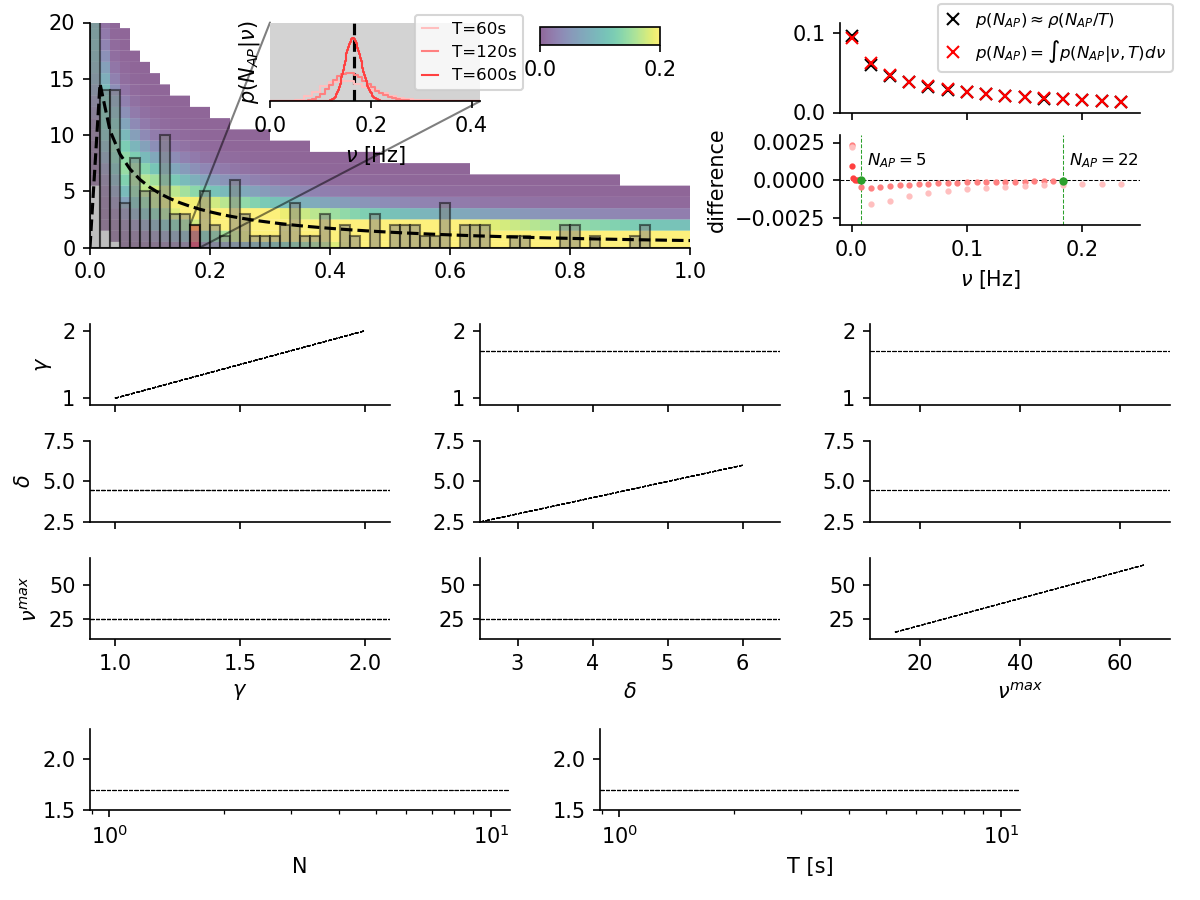

In [12]:
import warnings
import quadpy

warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")
from ipywidgets import interact, interactive, HBox, VBox, Output, FloatSlider

# n = params["N"]
# params = {"distr": [{"gamma": 2.1, "delta": 4.5, "nu_max": 25.0}]}
# T = params["T"]

plt.close("all")
fig = plt.figure(figsize=(8, 6), dpi=150)

ax_p_nu = fig.add_subplot([0.075, 0.725, 0.5, 0.25])
ax_cb = fig.add_subplot([0.45, 0.95, 0.1, 0.02])

# ax_single = fig.add_subplot([0.2, 0.9, 0.175, 0.075])

ax_probs = fig.add_subplot([0.7, 0.875, 0.25, 0.1])
ax_probs_difference = fig.add_subplot([0.7, 0.75, 0.25, 0.1])


steps = np.ceil(params["distr"][0]["nu_max"] * params["T"]).astype("int") + 1
w = 1.0 / params["T"]


""" 1. PLOT EXPECTED HISTOGRAM COUNT PROBABILITIES """
rate_xlim = 1.0
N_max = rate_xlim * params["T"]  # int(min(50,nu_max * T))
N_AP = np.arange(N_max)

k_AP = np.arange(params["N"])[:, np.newaxis]
binom = sp_binom(params["N"], k_AP)

### integrate to obtain probability for each N_AP
eps_pow = -6
p_N_AP_arr = quadpy.quad(
    f,
    0,
    params["distr"][0]["nu_max"],
    args=(
        params,
        N_AP[:, np.newaxis],
        params["T"],
    ),
    epsabs=10**eps_pow,
    epsrel=10**eps_pow,
    limit=100,
)[0][np.newaxis, :]

### calculate probability for each k_AP
p_k = binom * p_N_AP_arr**k_AP * (1 - p_N_AP_arr) ** (params["N"] - k_AP)
p_k[p_k < 10 ** (-4)] = np.NaN  # probabilities less than 1% are not displayed

X, Y = np.meshgrid(N_AP / params["T"], k_AP)
img = ax_p_nu.pcolor(
    X + w / 2, Y, p_k, shading="auto", clim=[0, 0.2], alpha=0.6, edgecolors=None
)
plt.colorbar(img, cax=ax_cb, orientation="horizontal")

# print(steps)
""" 2. PLOT DATA HISTOGRAM """
counts, bins = np.histogram(
    mP.rates[:, 0], bins=np.linspace(0, params["distr"][0]["nu_max"], steps)
)
N_highlight = 10
# print(counts,bins)
bars = ax_p_nu.bar(
    bins[:-1] + w / 2,
    counts,
    width=w,
    edgecolor="k",
    facecolor="tab:grey",
    alpha=0.5,
)

bar_hl = bars[N_highlight]
bar_hl.set_facecolor("tab:red")
# print(bars[N_highlight].get_height(),bars[N_highlight].get_width(),bars[N_highlight].get_x(),bars[N_highlight].get_y())


""" 3. PLOT FULL ANALYTICAL DISTRIBUTION """
nu_full = np.linspace(0, params["distr"][0]["nu_max"], steps)
p_full = p_nu(nu_full, params) / params["T"] * params["N"]
# print(f"p_full_norm: {p_full[:-1].sum()}")

ax_p_nu.plot(nu_full, p_full, "k--", label="from distribution")

plt.setp(
    ax_p_nu, xlim=[0, rate_xlim], ylim=[0, params["N"] / 10]
)  # , ylim=[0, 1.25 * np.nanmax(p_full)])


""" 4. PLOT DISTRIBUTION TO OBSERVE RATEWNT*T SPIKES """
# col = ["k", "b"]
rateWnt = N_highlight / params["T"]

x1, x2, y1, y2 = (
    bar_hl.get_x(),
    bar_hl.get_x() + bar_hl.get_width(),
    bar_hl.get_y(),
    bar_hl.get_y() + bar_hl.get_height(),
)
ax_p_NAP = ax_p_nu.inset_axes([0.3, 0.65, 0.35, 0.35], xlim=(x1, x2), ylim=(y1, y2))

ax_p_nu.indicate_inset_zoom(ax_p_NAP, edgecolor="black")
ax_p_NAP.set_facecolor("lightgrey")
# for r, rateWnt in enumerate([1.0]):  # , 3.]):
ax_p_NAP.axvline(rateWnt, linestyle="--", color="k")
# for i, T in enumerate([1, 10, 100]):
# for i, T in enumerate([10, 30, 60]):
# 	y_vals = f(nu_full, p=params, N_AP=np.array([rateWnt * T]), T=T)
# 	ax_single.step(
# 		nu_full,
# 		y_vals / y_vals.sum(),
# 		color=[1, (3 - i) / 4, (3 - i) / 4],
# 		# col[r],
# 		linewidth=1,
# 		# alpha=(4 - i) / 4,
# 		label=f"{T=}s",
# 	)  # ,label=f'$T={T}$')

# 	yy = y_vals[np.isfinite(y_vals)]


""" 5. PLOT DIFFERENCES BETWEEN EXACT AND APPROXIMATION """
rate_xlim = 0.25

# T = 30  # params["T"]
T = params["T"]
max_idx = int(rate_xlim * T)
ax_probs.plot(
    nu_full[:max_idx],
    p_nu(nu_full[:max_idx] + w / 2, params) / T,
    "kx",
    label=r"$p(N_{AP}) \approx \rho(N_{AP} / T)$",
)
p_N_AP_arr = quadpy.quad(
    f,
    0,
    params["distr"][0]["nu_max"],
    args=(
        params,
        N_AP[:max_idx, np.newaxis],  # [np.newaxis, :],
        T,
    ),
    epsabs=10**eps_pow,
    epsrel=10**eps_pow,
    limit=100,
)[0]
ax_probs.plot(
    N_AP[:max_idx] / T, p_N_AP_arr, "rx", label=r"$p(N_{AP})=\int p(N_{AP}|\nu,T) d\nu$"
)
plt.setp(ax_probs, xlim=[-0.01, rate_xlim * 1], xticklabels=[])
ax_probs.set_ybound(0, max(p_N_AP_arr) * 1.2)

ax_probs.legend(handlelength=1, fontsize=8, bbox_to_anchor=[0.3, 1.3], loc="upper left")

ax_probs_difference.axhline(0, color="k", linestyle="--", linewidth=0.5)
# for i, T in enumerate([5, 10, 20]):
max_y = 0
for i, T in enumerate([60, 120, 600]):
    steps = np.ceil(params["distr"][0]["nu_max"] * T).astype("int") + 1
    w = 1.0 / T

    N_max = int(rate_xlim * T)
    N_AP = np.arange(N_max)

    nu_full = np.linspace(0, params["distr"][0]["nu_max"], steps)
    p_full = p_nu(nu_full + w / 2, params) / T

    y_vals = f(nu_full, p=params, N_AP=np.array([rateWnt * T]), T=T)
    yy = y_vals[np.isfinite(y_vals)]
    max_y = max(max_y, np.nanmax(yy) / yy.sum() / w)
    # print(y_vals)
    ax_p_NAP.step(
        nu_full,
        y_vals / yy.sum() / w,
        color=[1, (3 - i) / 4, (3 - i) / 4],
        # col[r],
        linewidth=1,
        # alpha=(4 - i) / 4,
        label=f"{T=}s",
    )  # ,label=f'$T={T}$')

    p_N_AP_arr = quadpy.quad(
        f,
        0,
        params["distr"][0]["nu_max"],
        args=(
            params,
            N_AP[:N_max, np.newaxis],  # [np.newaxis, :],
            T,
        ),
        epsabs=10**eps_pow,
        epsrel=10**eps_pow,
        limit=100,
    )[0]

    dp = p_full[:N_max] - p_N_AP_arr
    # ax_probs_difference.plot(
    # 	nu_full[:N_max], dp, "o", color=[1,(3 - i) / 4,(3 - i) / 4], markersize=2, label=f"{T=}s",zorder=100+2*(2-i)-1
    # )

    j_min = 2
    idx_max = N_max
    found = False
    for j in range(N_max):
        ### correcting one at a time
        p_full[j] = p_N_AP_arr[j]
        dp_range = np.abs(dp[max(0, j - 3) : j + 1])
        if (
            j > j_min
            and np.all(np.abs(dp_range) < 10 ** (-4))
            # and np.all(abs(dp[j]) < dp_range[:-1])
        ):
            idx_max = j
            found = True
            print(f"approximation good enough @{j=}, {dp[j]}")
            # print(dp)

            break

            # ax_probs.plot(nu_full[:max_idx], p_nu(nu_full[:max_idx] + w / 2, params) / params["T"], "kx")
    ax_probs_difference.plot(
        nu_full[:idx_max],
        dp[:idx_max],
        "o",
        color=[1, (3 - i) / 4, (3 - i) / 4],
        markersize=2,
        label=f"{T=}s",
        zorder=100 + 2 * (2 - i) - 1,
    )
    if found:
        ax_probs_difference.axvline(
            nu_full[idx_max], color="tab:green", linestyle="--", linewidth=0.5
        )
        ax_probs_difference.text(
            nu_full[idx_max] + 0.005, 0.001, f"$N_{{AP}}={idx_max}$", fontsize=8
        )
        # ax_probs_difference.plot(nu_full[j:N_max], dp[j:N_max], "o", color=[(3 - i) / 4,1,(3 - i) / 4], markersize=2,zorder=100+2*i)
        ax_probs_difference.plot(
            nu_full[idx_max],
            dp[idx_max],
            "o",
            color="tab:green",
            markersize=3,
            zorder=110,
        )
ax_p_NAP.legend(
    handlelength=1, fontsize=8, bbox_to_anchor=(0.65, 1.2), loc="upper left"
)

plt.setp(ax_p_NAP, xlim=[0, rateWnt * 2.5], ylim=[0, 1.25 * max_y])
plt.setp(ax_p_NAP, yticks=[], xlabel="$\\nu$ [Hz]", ylabel="$p(N_{AP}|\\nu)$")


plt.setp(
    ax_probs_difference,
    xlim=[-0.01, rate_xlim],
    ylim=[-0.003, 0.003],
    xlabel="$\\nu$ [Hz]",
    ylabel="difference",
)
# ax_probs_difference.legend(loc="upper left",fontsize=8,handlelength=1,bbox_to_anchor=(0.65,1.4))
ax_probs_difference.spines[["top", "right"]].set_visible(False)

for axx in [ax_p_nu, ax_p_NAP, ax_probs]:
    axx.spines[["top", "right"]].set_visible(False)

ax_p_NAP.spines[["left"]].set_visible(False)

for i, key in enumerate(["gamma", "delta", "nu_max"]):
    ax_gamma = fig.add_subplot([0.075, 0.55 - i * 0.13, 0.25, 0.09])
    plot_results(
        ax_gamma,
        f"{key}_1",
        "gamma_1",
        np.linspace(1.0, 2.0, 11),
        n_repeat=100,
        save=False,
        log=False,
    )
    plt.setp(ax_gamma, xlim=[0.9, 2.1])

    ax_delta = fig.add_subplot([0.4, 0.55 - i * 0.13, 0.25, 0.09])
    plot_results(
        ax_delta,
        f"{key}_1",
        "delta_1",
        np.linspace(2.0, 6.0, 9),
        n_repeat=100,
        save=False,
        log=False,
    )
    plt.setp(ax_delta, xlim=[2.5, 6.5])

    ax_nu_max = fig.add_subplot([0.725, 0.55 - i * 0.13, 0.25, 0.09])
    plot_results(
        ax_nu_max,
        f"{key}_1",
        "nu_max_1",
        np.linspace(15.0, 65.0, 6),
        n_repeat=100,
        save=False,
        log=False,
    )
    plt.setp(ax_nu_max, xlim=[10, 70])

    for axx in [ax_gamma, ax_delta, ax_nu_max]:
        axx.spines[["top", "right"]].set_visible(False)

    for axx in [ax_gamma, ax_delta, ax_nu_max]:
        if key == "gamma":
            plt.setp(axx, ylim=[0.9, 2.1])
        elif key == "delta":
            plt.setp(axx, ylim=[2.5, 7.5])
        elif key == "nu_max":
            plt.setp(axx, ylim=[10, 70])

    if key == "gamma":
        plt.setp(ax_gamma, ylabel="$\gamma$")
    if key == "delta":
        plt.setp(ax_gamma, ylabel="$\delta$")
    if key == "nu_max":
        plt.setp(ax_gamma, ylabel="$\\nu^{max}$")
        plt.setp(ax_gamma, xlabel="$\gamma$")
        plt.setp(ax_delta, xlabel="$\delta$")
        plt.setp(ax_nu_max, xlabel="$\\nu^{max}$")
    else:
        for axx in [ax_gamma, ax_delta, ax_nu_max]:
            plt.setp(axx, xticklabels=[])

ax_N = fig.add_subplot([0.075, 0.1, 0.35, 0.09])
plot_results(
    ax_N,
    f"gamma_1",
    "N",
    [10, 20, 50, 100, 200, 500, 1000],
    n_repeat=100,
    save=False,
    log=True,
)
plt.setp(ax_N, ylim=[1.5, 2.3], xlabel="N")

ax_T = fig.add_subplot([0.5, 0.1, 0.35, 0.09])
plot_results(
    ax_T,
    f"gamma_1",
    "T",
    [5, 10, 30, 60, 120, 300, 500, 600, 1200],
    n_repeat=100,
    save=False,
    log=True,
)
plt.setp(ax_T, ylim=[1.5, 2.3], xlabel="T [s]")

for axx in [ax_N, ax_T]:
    axx.spines[["top", "right"]].set_visible(False)
plt.savefig("../figures/inference_results.png")

## expected bias

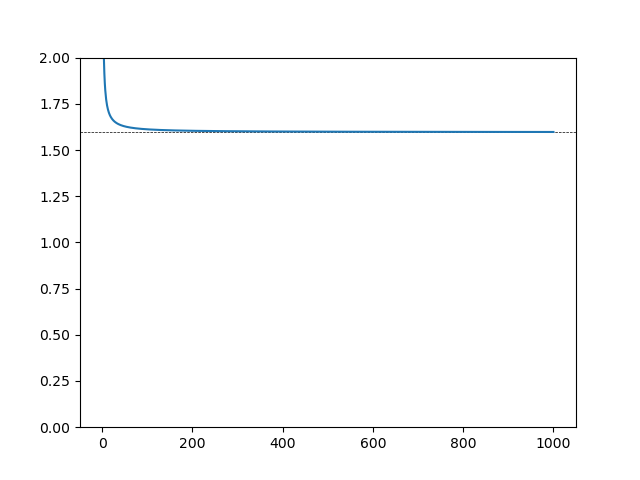

In [13]:
from DM_theory.functions import *

gamma = 1.7
delta = 4.5
nu_max = 25.0
nu_bar = get_nu_bar(gamma, delta, nu_max)
q = get_q(gamma, delta, nu_max)

n = np.linspace(0, 1000, 1001)

dnu = nu_bar + 1 / (2 * n) * (q / nu_bar - nu_bar)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(nu_bar, color="k", linestyle="--", linewidth=0.5)
ax.plot(n, dnu)
plt.setp(ax, ylim=[0, 2])
plt.show()

TypeError: p_nu() missing 2 required positional arguments: 'delta' and 'nu_max'

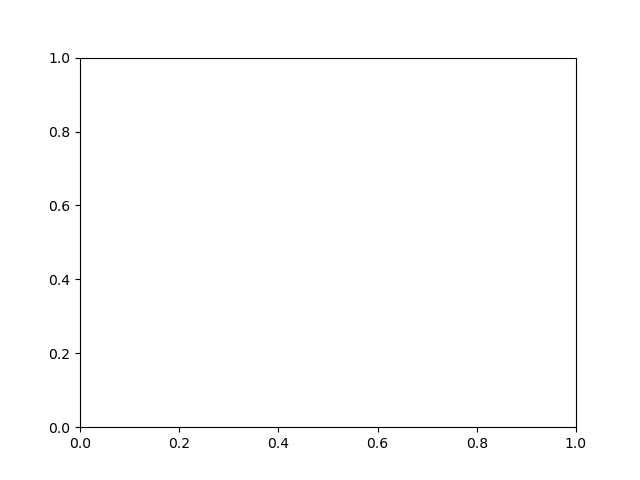

In [14]:
# print(p_N_AP_arr[0,:20])
# p_N_AP_arr.shape
# p_full_offset = p_nu(nu_full+w/2, params)
# print(p_full_offset[:20])
# print(nu_full,w)
# print(N_AP)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nu_full, p_nu(nu_full, params), "k-")
ax.plot(nu_full, p_nu(nu_full + w / 2, params), "r--")
ax.plot(
    nu_full[:-1], (p_nu(nu_full[:-1], params) + p_nu(nu_full[1:], params)) / 2, "g--"
)
ax.plot(N_AP / params["T"], p_N_AP_arr[0, :] * params["T"], "b")
plt.setp(ax, xlim=[0, 5])
# print(p_nu(nu_full, params)[:-1].sum())
# print(p_N_AP_arr.sum(),p_N_AP_arr)

In [17]:
steps = 51
gamma_array = np.linspace(1.0, 2.5, steps)
delta_array = np.linspace(1.0, 10.0, steps)
nu_max_array = np.linspace(10.0, 80.0, steps)

gamma_mesh, delta_mesh, nu_max_mesh = np.meshgrid(
    gamma_array, delta_array, nu_max_array, indexing="ij"
)

i, j, k = 10, 10, 10
gamma = gamma_mesh[i, j, k]
delta = delta_mesh[i, j, k]
nu_max = nu_max_mesh[i, j, k]

# print(f'{gamma=}, {delta=}, {nu_max=}')
# print(np.vstack([gamma_mesh[:,j,k],delta_mesh[:,j,k],nu_max_mesh[:,j,k]]).T)

logl = np.zeros((steps, steps, steps))
for j in range(steps):
    for k in range(steps):
        # print(j,k)
        logl[:, j, k] = my_logl(
            np.vstack(
                [gamma_mesh[:, j, k], delta_mesh[:, j, k], nu_max_mesh[:, j, k]]
            ).T
        )
# logl = my_logl(np.vstack([gamma_mesh[:,:,k],delta_mesh[:,:,k],nu_max_mesh[:,:,k]]).T)
logl

array([[[-3.34901000e+12, -2.30628800e+12, -1.58867900e+12, ...,
         -3.36437338e+03, -3.37850077e+03, -3.39780627e+03],
        [-3.34901000e+12, -2.30628800e+12, -1.58867900e+12, ...,
         -3.01930052e+03, -3.03229341e+03, -3.04951867e+03],
        [-3.34901000e+12, -2.30628800e+12, -1.58867900e+12, ...,
         -2.70511151e+03, -2.71698534e+03, -2.73220166e+03],
        ...,
        [-3.34901003e+12, -2.30628803e+12, -1.58867903e+12, ...,
         -2.21948134e+04, -2.21561425e+04, -2.21182729e+04],
        [-3.34901003e+12, -2.30628803e+12, -1.58867903e+12, ...,
         -2.34015035e+04, -2.33617351e+04, -2.33227899e+04],
        [-3.34901003e+12, -2.30628803e+12, -1.58867903e+12, ...,
         -2.46405936e+04, -2.45997278e+04, -2.45597070e+04]],

       [[-3.34901000e+12, -2.30628800e+12, -1.58867900e+12, ...,
         -3.36437338e+03, -3.37850077e+03, -3.39780627e+03],
        [-3.34901000e+12, -2.30628800e+12, -1.58867900e+12, ...,
         -3.01930052e+03, -3.03229341e

In [44]:
delta_mesh[..., 1]

array([[ 1.  ,  1.18,  1.36, ...,  9.64,  9.82, 10.  ],
       [ 1.  ,  1.18,  1.36, ...,  9.64,  9.82, 10.  ],
       [ 1.  ,  1.18,  1.36, ...,  9.64,  9.82, 10.  ],
       ...,
       [ 1.  ,  1.18,  1.36, ...,  9.64,  9.82, 10.  ],
       [ 1.  ,  1.18,  1.36, ...,  9.64,  9.82, 10.  ],
       [ 1.  ,  1.18,  1.36, ...,  9.64,  9.82, 10.  ]])

interactive(children=(IntSlider(value=10, description='i', max=50), IntSlider(value=10, description='j', max=5…

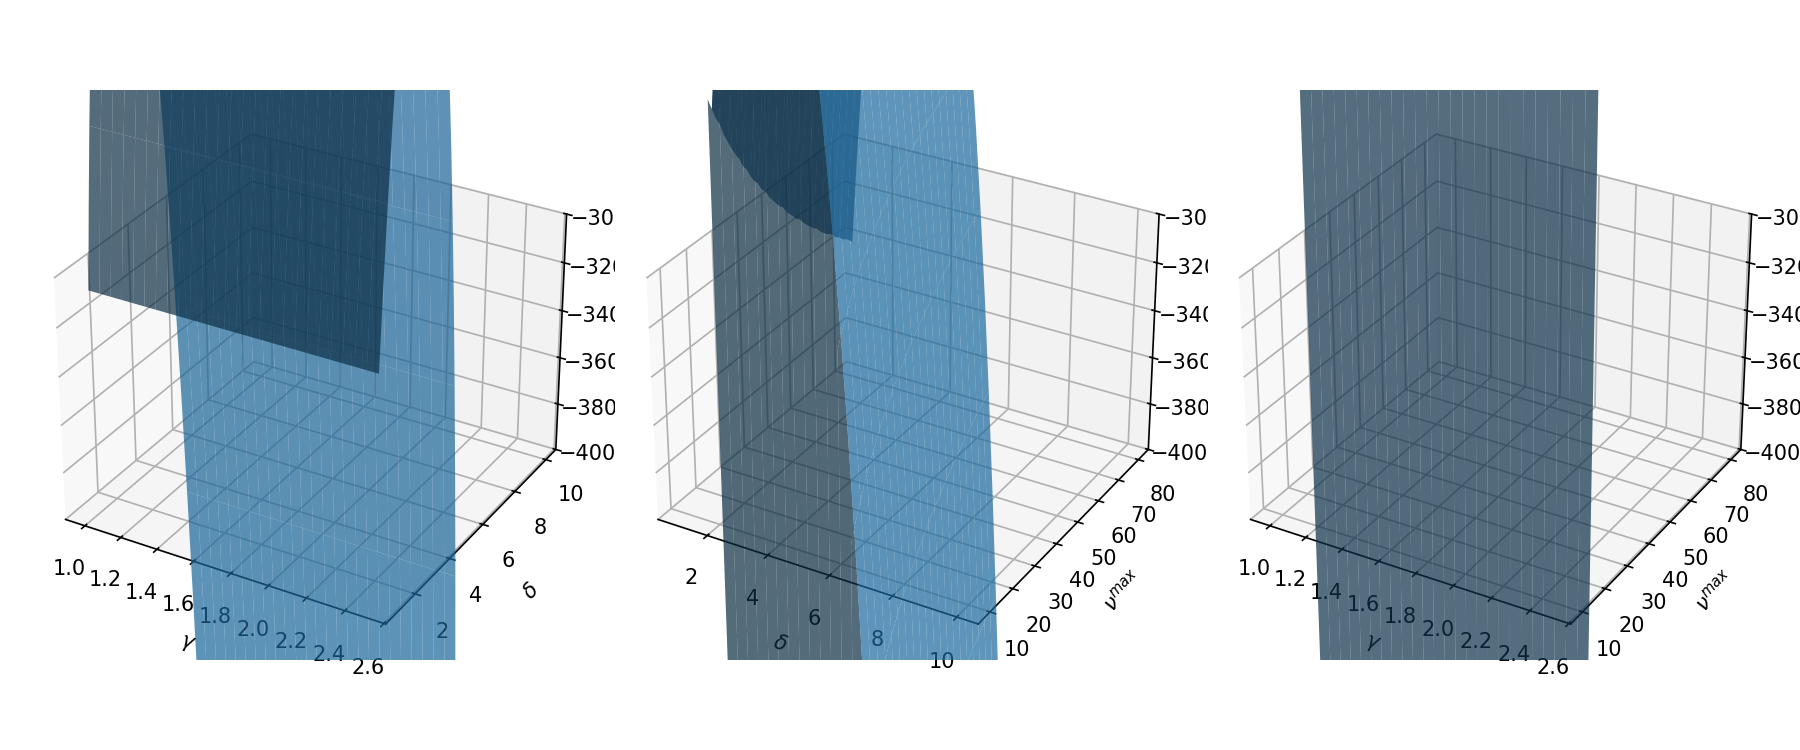

In [45]:
plt.close("all")
fig = plt.figure(figsize=(12, 5), dpi=150)
ax_nu = fig.add_subplot(131, projection="3d")
ax_gamma = fig.add_subplot(132, projection="3d")
ax_delta = fig.add_subplot(133, projection="3d")

plt.tight_layout()


@interact(i=(0, steps - 1), j=(0, steps - 1), k=(0, steps - 1))
def update_3d(i=10, j=10, k=30):

    for axx in [ax_gamma, ax_delta, ax_nu]:
        axx.clear()
    ax_gamma.plot_surface(
        delta_mesh[i, ...], nu_max_mesh[i, ...], logl[i, ...], alpha=0.7
    )
    ax_delta.plot_surface(
        gamma_mesh[:, j, :], nu_max_mesh[:, j, :], logl[:, j, :], alpha=0.7
    )
    ax_nu.plot_surface(
        gamma_mesh[..., k], delta_mesh[..., k], logl[:, :, k], alpha=0.7
    )  # ,cmap='viridis')#

    for axx in [ax_gamma, ax_delta, ax_nu]:
        plt.setp(axx, zlim=[-4000, -3000])

    plt.setp(ax_nu, xlabel="$\gamma$", ylabel="$\\delta$")
    plt.setp(ax_gamma, xlabel="$\delta$", ylabel="$\\nu^{max}$")
    plt.setp(ax_delta, xlabel="$\gamma$", ylabel="$\\nu^{max}$")

    print(
        f"$\\gamma=${gamma_array[i]}, $\\delta=${delta_array[j]}, $\\nu_m=${nu_max_array[k]}"
    )
    fig.canvas.draw_idle()

In [46]:
plt.close("all")

In [47]:
steps = 101
gamma_arr = np.linspace(1.0, 2.5, steps)
delta_arr = np.linspace(1.0, 10.0, steps)
nu_max = 25.0
gamma_mesh, delta_mesh = np.meshgrid(gamma_arr, delta_arr)

logl_mesh = np.zeros((steps, steps))
for j in range(steps):
    # print(j,k)
    logl_mesh[:, j] = my_logl(
        np.vstack([gamma_mesh[:, j], delta_mesh[:, j], np.full(steps, nu_max)]).T
    )
# logl = my_logl(np.vstack([gamma_mesh[:,:,k],delta_mesh[:,:,k],nu_max_mesh[:,:,k]]).T)
logl_mesh

array([[ -2493.54178358,  -2549.45404878,  -2607.17170043, ...,
        -16238.69956941, -16462.86907548, -16688.70805511],
       [ -2493.54178358,  -2549.45404878,  -2607.17170043, ...,
        -16238.69956941, -16462.86907548, -16688.70805511],
       [ -2493.54178358,  -2549.45404878,  -2607.17170043, ...,
        -16238.69956941, -16462.86907548, -16688.70805511],
       ...,
       [ -2493.54178358,  -2549.45404878,  -2607.17170043, ...,
        -16238.69956941, -16462.86907548, -16688.70805511],
       [ -2493.54178358,  -2549.45404878,  -2607.17170043, ...,
        -16238.69956941, -16462.86907548, -16688.70805511],
       [ -2493.54178358,  -2549.45404878,  -2607.17170043, ...,
        -16238.69956941, -16462.86907548, -16688.70805511]])

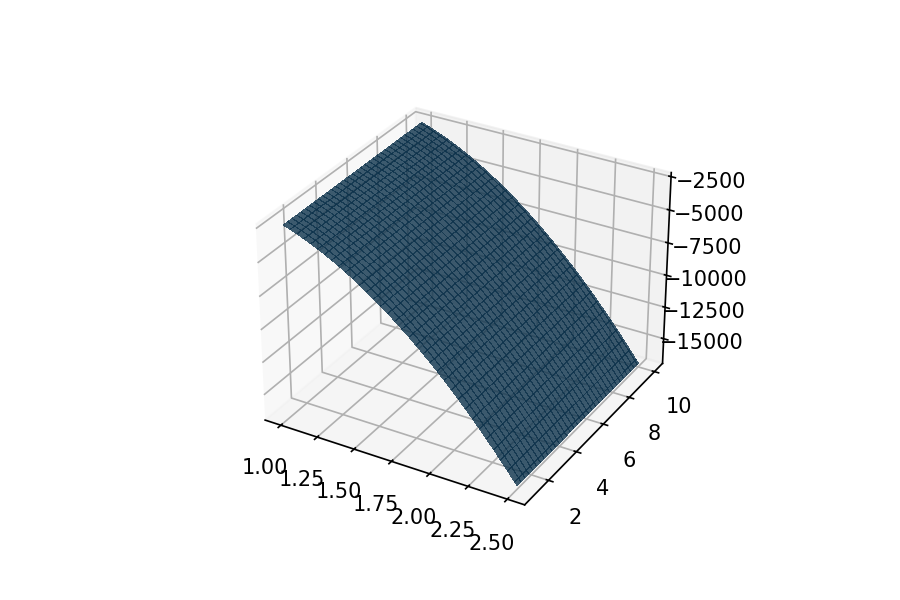

In [48]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(gamma_mesh, delta_mesh, logl_mesh, alpha=0.8, antialiased=False)
# plt.setp(ax, zlim=[-4000, -3000], xlabel="$\gamma$", ylabel="$\\delta$", zlabel="logL")
# ax.view_init(20, -15)